# Initial Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.feature_selection import SelectFromModel, RFE, RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

df = pd.read_csv("./kieranFeatures_1-30_26-Sep-2024.csv").drop(columns = "ID")
df.head()

,EDA_TonicMean_version02,EDA_TonicMean_version03,EDA_TonicMean_version04,EDA_TonicMean_version05,EDA_TonicMean_version09,EDA_TonicMean_version10,EDA_TonicMean_version11,EDA_TonicMean_version12,EDA_TonicMean_version16,EDA_TonicMean_version17,...,EEG_avgRelTheta_version16,EEG_avgRelTheta_version17,EEG_avgRelTheta_version19,EEG_avgRelTheta_version20,EEG_avgRelTheta_version22,EEG_avgRelTheta_version23,adjSA1,adjSA2,adjSA3,adjSAtotal
0,-0.123031,-0.226077,-1.220480,-1.697738,-0.273200,-0.601171,-0.809518,-1.012558,-0.299118,-0.469374,...,-1.877017,-1.442056,1.070298,1.277417,0.249605,0.400156,0.119790,1.593122,-0.800726,0.350233
1,-0.152896,-0.050866,1.527067,1.883468,-0.378060,-0.018812,1.023216,1.189124,-0.355315,-0.160570,...,-1.632698,-1.531970,1.779032,1.074498,0.409991,0.333842,0.075246,-1.663383,0.859309,-0.262893
2,-0.166035,-0.181478,1.634437,0.904620,-0.424192,-0.452936,1.123414,0.534554,-0.380039,-0.390771,...,-1.489450,-1.448590,2.194570,1.262672,0.504028,0.395338,-1.072729,0.879836,-1.542415,-0.938513
3,-0.231095,-0.209571,1.654951,1.247081,-0.652624,-0.546311,1.214370,0.821624,-0.502463,-0.440284,...,-1.353433,-1.059878,2.589134,2.139926,0.593317,0.682023,-0.643181,-0.217332,0.945816,0.145041
4,-0.236090,-0.323013,-0.478244,-1.080788,-0.670161,-0.923364,-0.421866,-0.775114,-0.511862,-0.640221,...,-1.443846,-0.627980,2.326862,3.114644,0.533965,1.000560,-0.323098,0.712401,-1.473404,-0.642872


# Pre-Processing

Divide up dataframe into predictors and outcomes. Train-test-split the following data.

In [2]:
# Create binary variables for high and low 
adj_SA_1_median = np.median(df["adjSA1"])
adj_SA_2_median = np.median(df["adjSA2"])
adj_SA_3_median = np.median(df["adjSA3"])
adj_SA_tot_median = np.median(df["adjSAtotal"])

# Will be high if adjusted SA level score is equal to or above median, low otherwise
df["Lv_1_Hi"] = (df["adjSA1"] >= adj_SA_1_median).astype(int)
df["Lv_2_Hi"] = (df["adjSA2"] >= adj_SA_2_median).astype(int)
df["Lv_3_Hi"] = (df["adjSA3"] >= adj_SA_3_median).astype(int)
df["Tot_Hi"] = (df["adjSAtotal"] >= adj_SA_tot_median).astype(int)

In [3]:
def split_data(df, n = 5814):
    # Separating predictors and outcomes
    predictors_df = df.iloc[:, 1:(df.shape[1] - 8)]
    predictors_df = predictors_df.sample(axis = "columns", n = n, replace = False, random_state = 42)
    outcomes_df = df.iloc[:, (df.shape[1] - 8):]

    # Split into train and test
    predictors_train, predictors_test, outcomes_train, outcomes_test = train_test_split(predictors_df, outcomes_df, test_size = 0.2, random_state = 42)

    # Scale the data
    scaler = StandardScaler()
    predictors_train = scaler.fit_transform(predictors_train)
    predictors_train = pd.DataFrame(predictors_train, columns = predictors_df.columns)
    predictors_test = scaler.transform(predictors_test)
    predictors_test = pd.DataFrame(predictors_test, columns = predictors_df.columns)

    return predictors_train, predictors_test, outcomes_train, outcomes_test

# Training Models

In [4]:
def n_features_cv_scores(df, n, outcome_var, folds):
    # Pre-Processing
    predictors_cv, predictors_test, outcomes_cv, outcomes_test = split_data(df, n)

    CV_scores = []
    kf = KFold(n_splits = folds, shuffle = True, random_state = 42)

    # Select features based on training set, evaluate on validation set
    for i, (train_index, val_index) in enumerate(kf.split(predictors_cv)):
        predictors_train = predictors_cv.iloc[train_index]
        predictors_val = predictors_cv.iloc[val_index]
        outcomes_train = outcomes_cv.iloc[train_index]
        outcomes_val = outcomes_cv.iloc[val_index]

        # Initialize model without regularization
        model = LogisticRegression(penalty = None, max_iter = 10000, fit_intercept = False, random_state = 42)
        model.fit(predictors_train, outcomes_train[outcome_var])

        # Evaluate model using selected features
        accuracy = model.score(predictors_val, outcomes_val[outcome_var])
        CV_scores.append(accuracy)

    return np.mean(CV_scores)

def top_n_features_LASSO_cv(df, n, outcome_var, folds):
    # Pre-Processing
    predictors_cv, predictors_test, outcomes_cv, outcomes_test = split_data(df)

    CV_scores = []
    kf = KFold(n_splits = folds, shuffle = True, random_state = 42)

    # Select features based on training set, evaluate on validation set
    for i, (train_index, val_index) in enumerate(kf.split(predictors_cv)):
        predictors_train = predictors_cv.iloc[train_index]
        predictors_val = predictors_cv.iloc[val_index]
        outcomes_train = outcomes_cv.iloc[train_index]
        outcomes_val = outcomes_cv.iloc[val_index]

        # Initialize model with L1 Regularization (LASSO)
        model = LogisticRegression(penalty = "l1", solver = "liblinear", max_iter = 10000, fit_intercept = False, random_state = 42)
        model.fit(predictors_train, outcomes_train[outcome_var])

        # Select Top n Features with LASSO
        selector = SelectFromModel(model, max_features = n, prefit = True, threshold = -np.inf)
        selected_features = selector.get_support(indices = True)

        predictors_train = predictors_train.iloc[:, selected_features]
        predictors_val = predictors_val.iloc[:, selected_features]

        # Evaluate model using selected features
        eval_model = LogisticRegression(solver = "liblinear", max_iter = 10000, fit_intercept = False, random_state = 42)
        eval_model.fit(predictors_train, outcomes_train[outcome_var])
        accuracy = eval_model.score(predictors_val, outcomes_val[outcome_var])
        CV_scores.append(accuracy)

    return np.mean(CV_scores)

def top_n_features_RFE_cv(df, n, outcome_var, folds):
    # Pre-Processing
    predictors_cv, predictors_test, outcomes_cv, outcomes_test = split_data(df)

    CV_scores = []
    kf = KFold(n_splits = folds, shuffle = True, random_state = 42)

    # Select features based on training set, evaluate on validation set
    for i, (train_index, val_index) in enumerate(kf.split(predictors_cv)):
        predictors_train = predictors_cv.iloc[train_index]
        predictors_val = predictors_cv.iloc[val_index]
        outcomes_train = outcomes_cv.iloc[train_index]
        outcomes_val = outcomes_cv.iloc[val_index]

        # Initialize model with L1 Regularization (LASSO)
        model = LogisticRegression(solver = "liblinear", max_iter = 10000, fit_intercept = False, random_state = 42)

        # Select n features with Recursive Feature Elimination
        rfe = RFE(estimator = model, n_features_to_select = n, step = 50)
        rfe.fit(predictors_train, outcomes_train[outcome_var])

        # Evaluate model using selected features
        accuracy = rfe.score(predictors_val, outcomes_val[outcome_var])
        CV_scores.append(accuracy)

    return np.mean(CV_scores)

In [4]:
n_vals = [5814, 2500, 1000, 500, 250, 100]
SA_levels = ["Lv_1_Hi", "Lv_2_Hi", "Lv_3_Hi", "Tot_Hi"]

reg_cv_scores = {
    "Lv_1_Hi": [],
    "Lv_2_Hi": [],
    "Lv_3_Hi": [],
    "Tot_Hi": []
}

LASSO_cv_scores = {
    "Lv_1_Hi": [],
    "Lv_2_Hi": [],
    "Lv_3_Hi": [],
    "Tot_Hi": []
}

RFE_cv_scores = {
    "Lv_1_Hi": [],
    "Lv_2_Hi": [],
    "Lv_3_Hi": [],
    "Tot_Hi": []
}

In [7]:
# Takes a long time
# Get CV Scores from different n features
for n in n_vals:
    for lvl in SA_levels:
        reg_cv_scores[lvl].append(n_features_cv_scores(df, n, lvl, 10))
        LASSO_cv_scores[lvl].append(top_n_features_LASSO_cv(df, n, lvl, 10))
        RFE_cv_scores[lvl].append(top_n_features_RFE_cv(df, n, lvl, 10))
        print("Done with " + lvl + " for " + str(n) + " features")

Done with Lv_1_Hi for 5814features
Done with Lv_2_Hi for 5814features
Done with Lv_3_Hi for 5814features
Done with Tot_Hi for 5814features
Done with Lv_1_Hi for 2500features
Done with Lv_2_Hi for 2500features
Done with Lv_3_Hi for 2500features
Done with Tot_Hi for 2500features
Done with Lv_1_Hi for 1000features
Done with Lv_2_Hi for 1000features
Done with Lv_3_Hi for 1000features
Done with Tot_Hi for 1000features
Done with Lv_1_Hi for 500features
Done with Lv_2_Hi for 500features
Done with Lv_3_Hi for 500features
Done with Tot_Hi for 500features
Done with Lv_1_Hi for 250features
Done with Lv_2_Hi for 250features
Done with Lv_3_Hi for 250features
Done with Tot_Hi for 250features
Done with Lv_1_Hi for 100features
Done with Lv_2_Hi for 100features
Done with Lv_3_Hi for 100features
Done with Tot_Hi for 100features


Performance Graph for CV

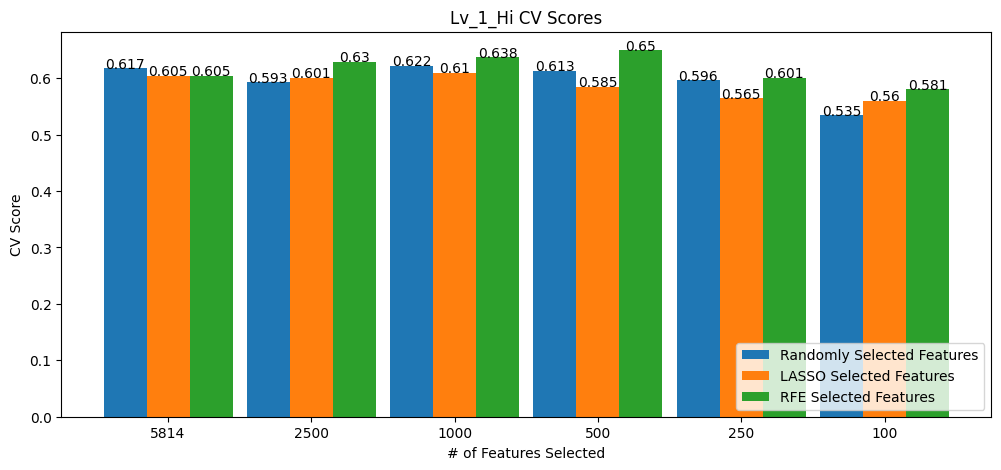

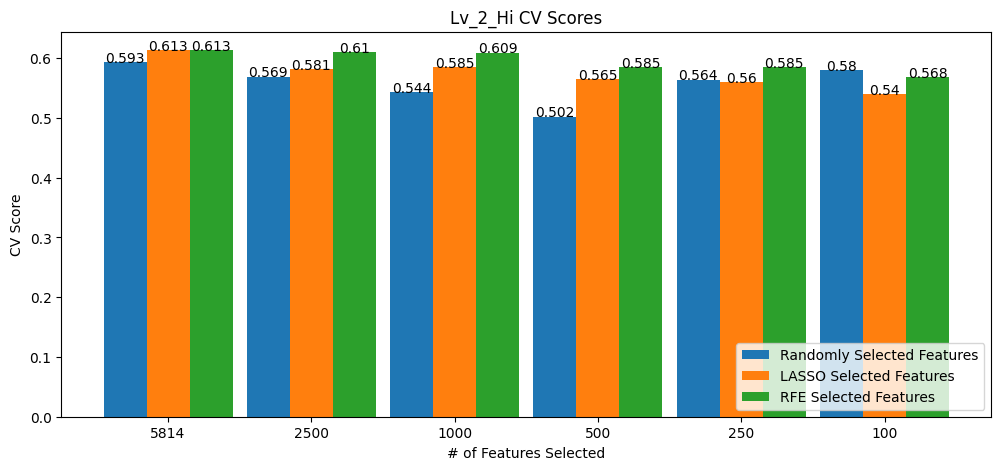

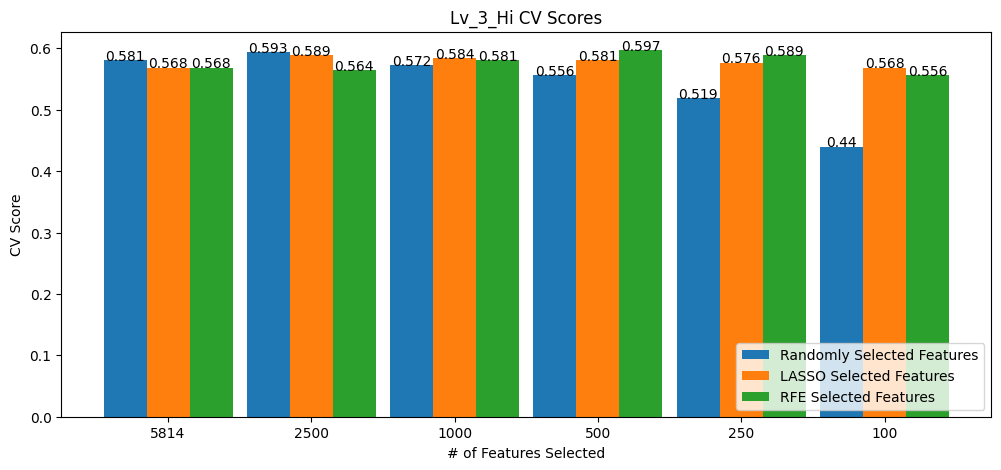

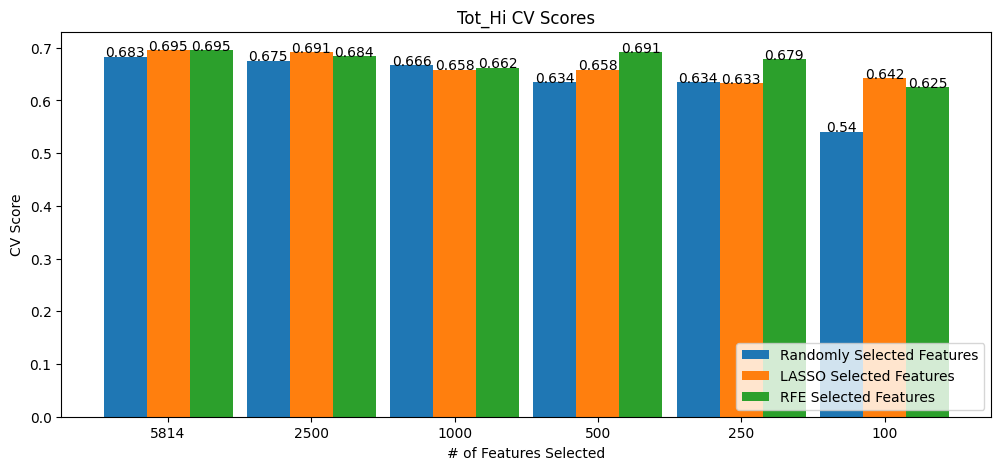

In [21]:
reg_cv_scores_df = pd.DataFrame(data = reg_cv_scores, index = n_vals)
LASSO_cv_scores_df = pd.DataFrame(data = LASSO_cv_scores, index = n_vals)
RFE_cv_scores_df = pd.DataFrame(data = RFE_cv_scores, index = n_vals)

for lvl in SA_levels:
    plt.figure(figsize = (12, 5))
    idx = np.arange(len(n_vals))
    width = 0.3

    plt.bar(idx - width * 0.5, reg_cv_scores_df[lvl], width, label = "Randomly Selected Features")
    for i in idx:
        plt.text(i - width * 0.5, reg_cv_scores_df.loc[n_vals[i], lvl], round(reg_cv_scores_df.loc[n_vals[i], lvl], 3), ha = "center")
    plt.bar(idx + width * 0.5, LASSO_cv_scores_df[lvl], width, label = "LASSO Selected Features")
    for i in idx:
        plt.text(i + width * 0.5, LASSO_cv_scores_df.loc[n_vals[i], lvl], round(LASSO_cv_scores_df.loc[n_vals[i], lvl], 3), ha = "center")
    plt.bar(idx + width * 1.5, RFE_cv_scores_df[lvl], width, label = "RFE Selected Features")
    for i in idx:
        plt.text(i + width * 1.5, RFE_cv_scores_df.loc[n_vals[i], lvl], round(RFE_cv_scores_df.loc[n_vals[i], lvl], 3), ha = "center")

    plt.title(lvl + " CV Scores")
    plt.xlabel("# of Features Selected")
    plt.ylabel("CV Score")

    plt.xticks(idx + width / 2, [str(n) for n in n_vals])

    plt.legend(loc = "lower right")

## Free Roam Models

LASSO

In [6]:
for lvl in SA_levels:
    predictors_train, predictors_test, outcomes_train, outcomes_test = split_data(df)

    model = LogisticRegression(penalty = "l1", solver = "liblinear", max_iter = 10000, fit_intercept = False, random_state = 42)
    params = {
        "C": [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 2000.0, 3000.0, 4000.0, 5000.0, 6000.0, 7000.0, 8000.0, 9000.0, 10000.0]
    }

    clf = GridSearchCV(estimator = model, param_grid = params, cv = 10, scoring = "accuracy", n_jobs = -1)
    clf.fit(predictors_train, outcomes_train[lvl])

    print(clf.best_score_, clf.best_params_, np.sum(clf.best_estimator_.coef_ != 0))

0.6793333333333333 {'C': 5000.0} 2819
0.6216666666666667 {'C': 7000.0} 3476
0.5756666666666667 {'C': 0.1} 77
0.7121666666666667 {'C': 3000.0} 1860


RFE

In [ ]:
for lvl in SA_levels:
    predictors_train, predictors_test, outcomes_train, outcomes_test = split_data(df)

    model = LogisticRegression(penalty = "l1", solver = "liblinear", max_iter = 10000, fit_intercept = False)
    selector = RFECV(model, cv = 10, scoring = "accuracy", n_jobs = -1)

    print(clf.best_score_, clf.best_params_, np.sum(clf.best_estimator_.coef_ != 0))

In [49]:
# 10.5 mins
predictors_train, predictors_test, outcomes_train, outcomes_test = split_data(df)
model = LogisticRegression(penalty = None, max_iter = 10000, fit_intercept = False)
selector = RFECV(model, cv = 10, scoring = "accuracy", n_jobs = -1)
selector = selector.fit(predictors_train, outcomes_train["Lv_1_Hi"])
selector.support_

array([ True, False,  True, ...,  True, False,  True])

In [50]:
a = pd.DataFrame(data = selector.cv_results_)

# Evaluating Model Performance (Accuracy)

In [28]:
def get_test_scores(df, outcome_var, n_features):
    test_scores = {
        "No Penalty": 0.0,
        "LASSO": 0.0,
        "RFE": 0.0
    }

    # No Penalty Model
    pred_reg_train, pred_reg_test, out_reg_train, out_reg_test = split_data(df, n_features[0])
    reg_model = LogisticRegression(penalty = None, max_iter = 10000, fit_intercept = False, random_state = 42)
    reg_model.fit(pred_reg_train, out_reg_train[outcome_var])
    test_scores["No Penalty"] = reg_model.score(pred_reg_test, out_reg_test[outcome_var])

    # LASSO Model
    pred_lasso_train, pred_lasso_test, out_lasso_train, out_lasso_test = split_data(df)
    LASSO_model = LogisticRegression(penalty = "l1", solver = "liblinear", max_iter = 10000, fit_intercept = False, random_state = 42)
    LASSO_model.fit(pred_lasso_train, out_lasso_train[outcome_var])
    LASSO_selector = SelectFromModel(LASSO_model, max_features = n_features[1], prefit = True, threshold = -np.inf)
    LASSO_selected_features = LASSO_selector.get_support(indices = True)
    pred_lasso_train = pred_lasso_train.iloc[:, LASSO_selected_features]
    pred_lasso_test = pred_lasso_test.iloc[:, LASSO_selected_features]
    LASSO_eval_model = LogisticRegression(max_iter = 10000, fit_intercept = False, random_state = 42)
    LASSO_eval_model.fit(pred_lasso_train, out_lasso_train[outcome_var])
    test_scores["LASSO"] = LASSO_eval_model.score(pred_lasso_test, out_lasso_test[outcome_var])

    # RFE Model
    pred_rfe_train, pred_rfe_test, out_rfe_train, out_rfe_test = split_data(df)
    RFE_model = RFE(estimator = LogisticRegression(max_iter = 10000, fit_intercept = False, random_state = 42, n_jobs = -1), n_features_to_select = n_features[2])
    RFE_model.fit(pred_rfe_train, out_rfe_train[outcome_var])
    test_scores["RFE"] = RFE_model.score(pred_rfe_test, out_rfe_test[outcome_var])

    return test_scores

def plot_test_scores(test_scores, SA_lvl):
    errors = [1.96 * np.sqrt(val * (1 - val) / 61) for val in test_scores.values()]

    plt.figure(figsize = (5, 5))
    idx = np.arange(len(test_scores.values()))

    plt.bar(idx, test_scores.values())
    for i in idx:
        plt.text(i, list(test_scores.values())[i], round(list(test_scores.values())[i], 3), ha = "right", va = "top")
    plt.errorbar(idx, test_scores.values(), yerr = errors, fmt = "o", c = "black")
    plt.axhline(y = 0.5, color = "r")

    plt.title(SA_lvl + " Accuracy Scores")
    plt.xlabel("Feature Selection Type")
    plt.ylabel("Accuracy")

    plt.xticks(idx, list(test_scores.keys()))

SA 1

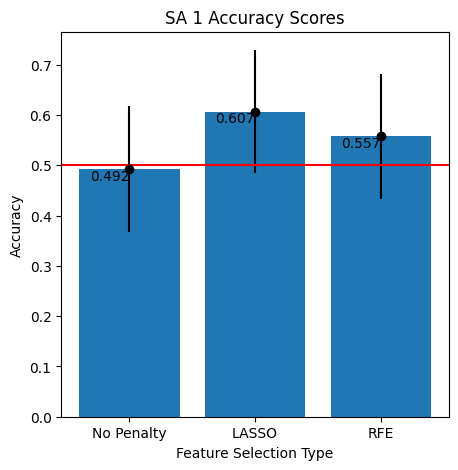

In [29]:
test_scores_SA_1 = get_test_scores(df, "Lv_1_Hi", [1000, 1000, 500])
plot_test_scores(test_scores_SA_1, "SA 1")

SA 2

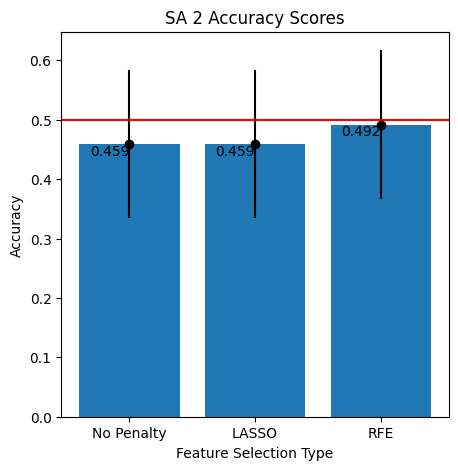

In [30]:
test_scores_SA_2 = get_test_scores(df, "Lv_2_Hi", [5814, 1000, 2500])
plot_test_scores(test_scores_SA_2, "SA 2")

SA 3

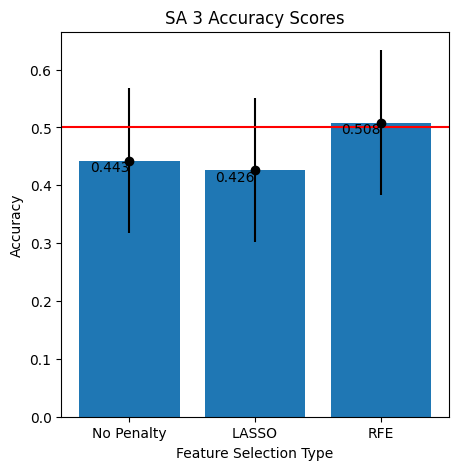

In [31]:
test_scores_SA_3 = get_test_scores(df, "Lv_3_Hi", [2500, 2500, 500])
plot_test_scores(test_scores_SA_3, "SA 3")

Total SA

In [32]:
test_scores_SA_tot = get_test_scores(df, "Tot_Hi", [5814, 2500, 500])
plot_test_scores(test_scores_SA_tot, "Total SA")

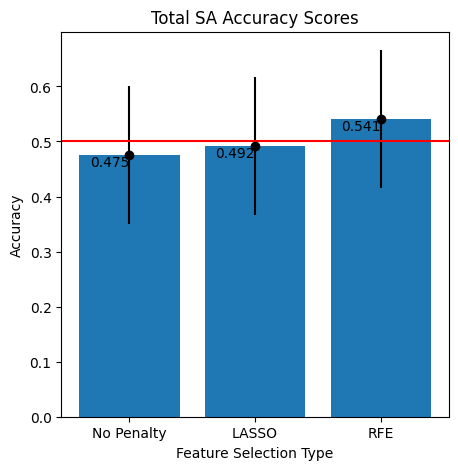

In [33]:
plot_test_scores(test_scores_SA_tot, "Total SA")